> La carte d'occupation du sol de Wallonie de 2019 et la carte des changements ont été réalisées dans le cadre du marché de mise à jour de WalOUS 2018 entre le SPW et Aerospacelab. Ce notebook a été réalisé afin de former les utilisateurs à l'utilisation des données dérivées de ce marché.

# Atelier Utilisateurs #2
## Repartition

Dans ce _notebook_, l'ambition est de voir comment des cartes thématiques peuvent être générer à partir de la carte d'occupation du sol en format _raster_

Ce cas pratique nous permettra de toucher les points suivants:
- générer des données vectorisées
- calculer la proportion/répartition d'une classe
- illustrer la répartition spatiale des données suivant une thématique

Commençons d'abord par importer les librairies qui seront utilisées dans ce _notebook_:

In [14]:
from pathlib import Path
from typing import Dict, List, Tuple, Union

from geojson import Feature
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import rasterio as rio
from rasterio.enums import Resampling
from rasterio.features import geometry_window, shapes
from rasterio import windows
from tqdm.notebook import tqdm

Redéfinissons les variables et fonctions définies dans le _notebook_ __familiarisation__:

In [15]:
OCS_TITLES = {
        1: "Revêtement artificiel au sol",
        2: "Constructions artificielles hors sol",
        3: "Réseau ferroviaire",
        4: "Sols nus",
        5: "Eaux de surface",
        6: "Couvert herbacé en rotation",
        7: "Couvert herbacé toute l'année",
        8: "Résineux (> 3m)",
        9: "Feuillus (> 3m)",
        11: "Revêtement artificiel au sol (pont)",
        15: "Revêtement artificiel au sol (sous eau)",
        18: "Revêtement artificiel au sol (sous résineux)",
        19: "Revêtement artificiel au sol (sous feuillus)",
        28: "Constr. artificielles hors sol (sous résineux)",
        29: "Constr. artificielles hors sol (sous feuillus)",
        31: "Pont au dessus du réseau ferroviaire",
        38: "Réseau ferroviaire (sous résineux)",
        39: "Réseau ferroviaire (sous feuillus)",
        51: "Ponts sur l'eau",
        55: "Eaux de surface (2 niveaux)",
        58: "Eaux de surface (sous résineux)",
        59: "Eaux de surface (sous feuillus)",
        62: "Serres",
        71: "Couvert herbacé toute l'année (sous pont)",
        73: "Couvert herbacé toute l'année (sous réseau ferroviaire)",
        75: "Couvert herbacé toute l'année (sous pont-canal)",
        80: "Résineux (≤ 3m)",
        81: "Résineux (sous pont)",
        83: "Résineux (sous réseau ferroviaire)",
        85: "Résineux (sous pont - canal)",
        90: "Feuillus (≤ 3m)",
        91: "Feuillus (sous pont)",
        93: "Feuillus (sous réseau ferroviaire)",
        95: "Feuillus (sous pont - canal)",
    }

OCS_CMAP = {
    1: (138, 138, 138),
    2: (220, 15, 15),
    3: (78, 78, 78),
    4: (208, 208, 208),
    5: (36, 97, 247),
    6: (255, 255, 115),
    7: (233, 255, 190),
    8: (0, 50, 0),
    9: (40, 200, 40),
    11: (138, 138, 138),
    15: (138, 138, 138),
    18: (138, 138, 138),
    19: (138, 138, 138),
    28: (220, 15, 15),
    29: (220, 15, 15),
    31: (78, 78, 78),
    38: (78, 78, 78),
    39: (78, 78, 78),
    51: (36, 97, 247),
    55: (36, 97, 247),
    58: (36, 97, 247),
    59: (36, 97, 247),
    62: (255, 85, 0),
    71: (233, 255, 190),
    73: (233, 255, 190),
    75: (233, 255, 190),
    80: (0, 120, 0),
    81: (0, 50, 0),
    83: (0, 50, 0),
    85: (0, 50, 0),
    90: (183, 232, 176),
    91: (40, 200, 40),
    93: (40, 200, 40),
    95: (40, 200, 40),
    255: (255, 255, 255),  # Nodata
}

def to_mapping_array(mapping_dict: Dict[int, Union[int, List[int]]]) -> np.ndarray:
    k = np.array(list(mapping_dict.keys()))
    v = np.array(list(mapping_dict.values()))
    if v.ndim > 1:
        map_array_shape = (k.max() + 1, v.shape[1])
    else:
        map_array_shape = k.max() + 1
    mapping_array = np.zeros(map_array_shape, dtype="uint8")
    mapping_array[k] = v
    return mapping_array

def raster2img(data: np.ndarray, cmap: Dict[int, Tuple[int, int, int]] = OCS_CMAP):
    ocs_cmap_encoding = to_mapping_array(cmap)
    return Image.fromarray(ocs_cmap_encoding[data.squeeze()])

--------

#### Carte thématique: proportion de forêt feuillus dans une zone d'intérêt

Nous allons illustrer comment générer une carte thématique indiquant la proportion de forêt de feuillus dans une zone d'intérêt prédéfinie.<br>
Déterminons cette zone d'intérêt près de Philippeville et chargons celle-ci dans un `GeoDataFrame`:

In [7]:
AOI_FP = "data/aoi_philippeville.geojson"

aoi = gpd.read_file(AOI_FP)
print(f"La zone d'intérêt a une surface de {round(aoi.iloc[0].geometry.area, 2)} et a un CRS {aoi.crs}")

La zone d'intérêt a une surface de 35824864.44 et a un CRS epsg:31370


Visualisons où se trouve cette zone d'intérêt sur une carte de la Wallonie:

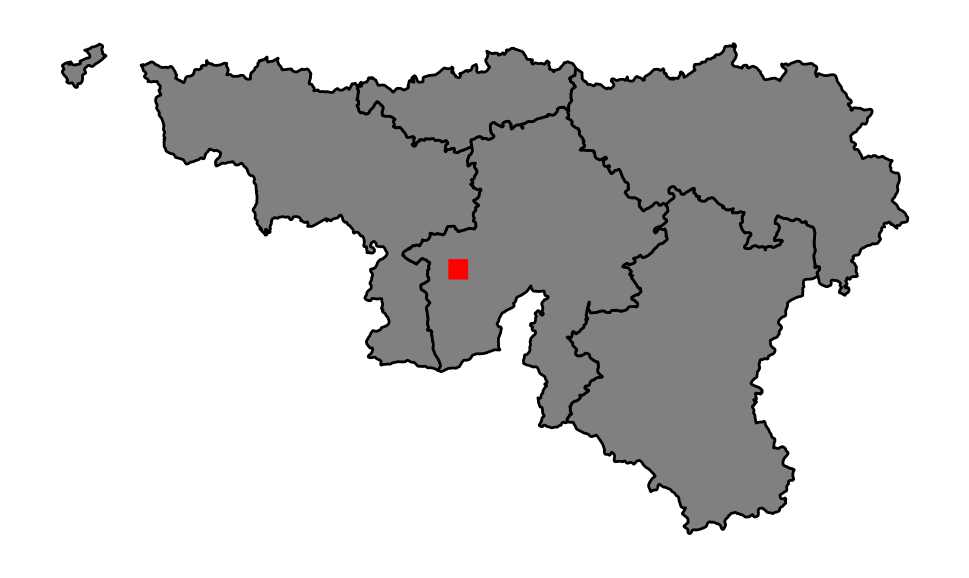

In [4]:
%matplotlib inline
plt.rcParams['figure.dpi'] = 200

belgium = gpd.read_file("data/belgian_provinces.zip!provinces_L08.shp")
wallonia = belgium[belgium["provISO"].str.startswith("W")]

basemap = wallonia.plot(color="grey", edgecolor="black")
fig = aoi.to_crs(wallonia.crs).plot(ax=basemap, color="red")
fig.set_axis_off()

Pour cette carte thématique, nous allons considérer la proportion de feuillus dans chacune des _tuiles_ contenues dans la zone d'intérêt. Pour cela, nous aurons besoin du fichier tuilage.

Nous chargons cette donnée avec la librairie `geopandas` et nous filtrons pour ne garder uniquement les _tuiles_ ayant une intersection avec l'AOI. Celles-ci sont stockées dans un `GeoDataFrame` qui peut être regardé comme un tableau.

In [8]:
TUILAGE_FP = "data/ORTHOS_2018_MAILLES_TUILES_SHAPE_31370.zip!SPW_2018_TUILAGE.shp"

tuilage_gdf = gpd.read_file(TUILAGE_FP, bbox=aoi)
tuilage_gdf.head(5)  # Affichage des 5 premières lignes

/opt/anaconda3/envs/walous/lib/python3.7/site-packages/geopandas/geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


,OBJECTID,IMGLV3NAME,ACQ_TIME,ACQ_TIMEST,BANDS,RADIO_RES,SUN_ELEVAT,SUN_AZIMUT,AVG_HEIGHT,AER_HEIGHT,...,IMG_MOSDES,CKP_SOURCE,CKP_ACC_XY,CKP_ACC_Z,CKP_NUMBER,CKP_RMSE_X,CKP_RMSE_Y,CKP_RMSEXY,IMGORTNAME,geometry
0,1327.0,LV3_2018__2_042B_03726,20180701152323,15:23:23,4,64,40.09,257.8,249.56,4204.106,...,Global tiling,PICC,0.12,0.2,12,0.221,0.143,0.263,ORTHO_2018__00500080;ORTHO_2018__00510080;ORTH...,"POLYGON ((161523.500 104082.251, 161579.750 10..."
1,1328.0,LV3_2018__2_042B_03727,20180701153838,15:38:38,4,64,37.71,261.1,238.79,4211.117,...,Global tiling,PICC,0.12,0.2,12,0.221,0.143,0.263,ORTHO_2018__00500080;ORTHO_2018__00510080;ORTH...,"POLYGON ((161188.500 104047.001, 161191.250 10..."
2,1329.0,LV3_2018__2_042B_03728,20180701155252,15:52:52,4,64,35.46,264.0,240.36,4205.935,...,Global tiling,PICC,0.12,0.2,12,0.221,0.143,0.263,ORTHO_2018__00500079;ORTHO_2018__00500080;ORTH...,"POLYGON ((159934.500 103743.751, 159956.500 10..."
3,1330.0,LV3_2018__2_042B_03729,20180701150606,15:06:06,4,64,42.80,253.9,244.38,4205.021,...,Global tiling,PICC,0.12,0.2,12,0.221,0.143,0.263,ORTHO_2018__00500078;ORTHO_2018__00500079;ORTH...,"POLYGON ((159551.500 103768.001, 159575.250 10..."
4,1331.0,LV3_2018__2_042B_03730,20180701152020,15:20:20,4,64,40.61,257.1,240.77,4208.069,...,Global tiling,PICC,0.12,0.2,12,0.221,0.143,0.263,ORTHO_2018__00500078;ORTHO_2018__00500079;ORTH...,"POLYGON ((157893.750 104026.251, 157923.750 10..."


Nous pouvons également afficher ces _tuiles_ sur la carte de la Wallonie pour vérifier que notre approche donne les résultats escomptés:

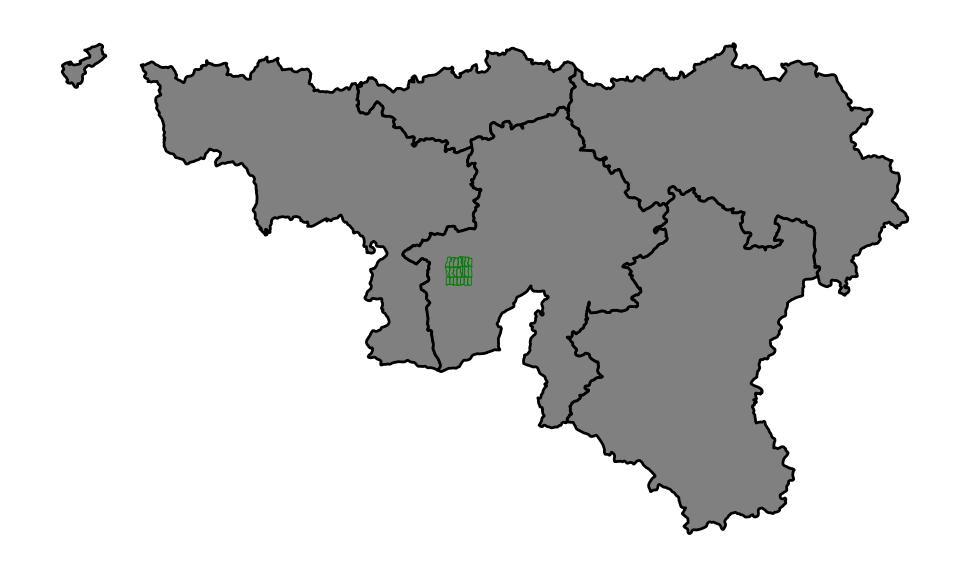

In [27]:
%matplotlib inline
plt.rcParams['figure.dpi'] = 200

belgium = gpd.read_file("data/belgian_provinces.zip!provinces_L08.shp")
wallonia = belgium[belgium["provISO"].str.startswith("W")]

basemap = wallonia.plot(color="grey", edgecolor="black")
fig = tuilage_gdf.to_crs(wallonia.crs).plot(
    ax=basemap, color=(0,0,0,0), edgecolor="green", linewidth=0.3
)
fig.set_axis_off()

En effet, toutes les _tuiles_ (vert) qui touchent la zone d'intérêt (rouge) ont été gardées:

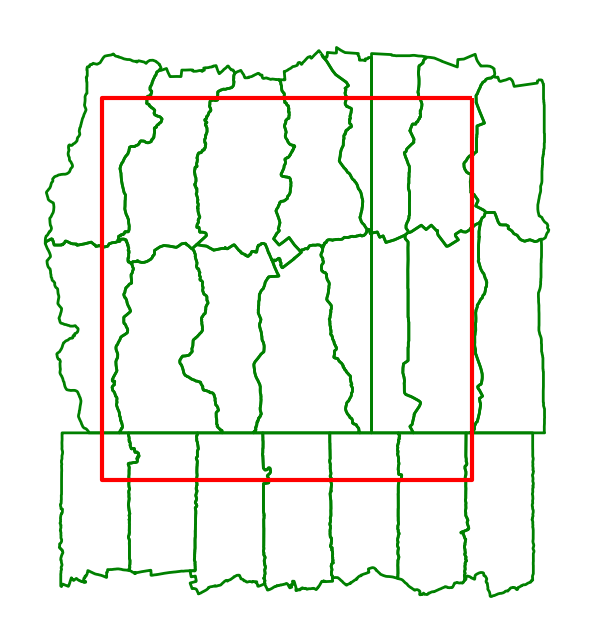

In [11]:
tuilage = tuilage_gdf.to_crs(aoi.crs).plot(color=(0,0,0,0), edgecolor="green")
aoi.boundary.plot(ax=tuilage, edgecolor="red").set_axis_off()

Afin de connaitre la proportion d'une certaine classe dans chacune de ces tuiles, nous pouvons travailler directement sur la donnée raster de la carte d'occupation du sol. Mais pour ce cas pratique, nous allons nous forcer à vectoriser le raster pour illustrer cette manipulation.

Puisque nous devons vectoriser une grande surface, nous procéderons d'abord à un rééchantillonnage de la donnée afin d'alléger le processus de vectorisation:

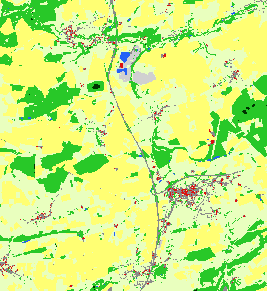

In [18]:
OCS_RASTER_FP = "data/WAL_OCS_IA__2019.tif"  # chemin d'accès au WAL_OCS

FACTEUR_AGRANDISSEMENT = 1/30  # Facteur pour l'échantillonnage
# Un facteur de 1/30 implique que chaque groupe de 30x30 pixels sera rééchantilloné en un seul pixel


with rio.open(OCS_RASTER_FP) as r:

    # Détermination de la fenêtre de lecture
    window = geometry_window(r, [tuilage_gdf.to_crs(r.crs).geometry])

    # Ouverture du raster, lecture des données dans la fenêtre et rééchantillonnage
    data = r.read(
        window=window,
        out_shape=(
            r.count,
            int(window.height * FACTEUR_AGRANDISSEMENT),
            int(window.width * FACTEUR_AGRANDISSEMENT)
        ),
        resampling=Resampling.mode
    )

    # Ajustement des métadonnées
    window_transform = windows.transform(window, r.transform)
    transform = window_transform * window_transform.scale(
        (window.width / data.shape[-1]),
        (window.height / data.shape[-2])
    )
    meta = r.meta
    meta["transform"] = transform
    meta["width"] = data.shape[-1]
    meta["height"] = data.shape[-2]

raster2img(data)

Vectorisons à présent ce raster.<br>
Cette étape peut se faire à l'aide de la librairie `rasterio` et de sa fonction `features.shapes`.<br>
Chaque zone homogène du raster est convertie en polygone et la valeur associée à cette zone extraite. Le tout est sauvé dans une `Feature` et l'ensemble de ces `Feature`s est stocké dans un `GeoDataFrame`.

_Note: Le paramètre `connectivity` propose deux options (4 ou 8) permettant de décider si les pixels de la même classe ne se touchant qu'en diagonale doivent faire partie du même polygone. L'option 4 ne considère comme voisins que les pixels du haut, bas, gauche, et droite d'un autre pixel. L'option 8 inclut les 4 autres positions découlant des deux diagonales._

In [19]:
features = []
for polygon, value in shapes(data, transform=transform, connectivity=4):
    features.append(Feature(geometry=polygon, properties={"label": int(value)}))
vect_gdf = gpd.GeoDataFrame.from_features(features, crs=meta["crs"])
vect_gdf.head(5)

,geometry,label
0,"POLYGON ((656812.804 604138.420, 656812.804 60...",6
1,"POLYGON ((656992.982 604138.420, 656992.982 60...",6
2,"POLYGON ((657173.160 604138.420, 657173.160 60...",7
3,"POLYGON ((658554.527 604138.420, 658554.527 60...",7
4,"POLYGON ((658944.913 604138.420, 658944.913 60...",9


Nous pouvons dès lors calculer la proportion des feuillus (i.e. classe 9) dans chacune des tuiles en comparant leurs surfaces respectives.<br>
Nous sauvons ces résultats pour chaque tuile dans le `GeoDataFrame` __tuilage_gdf__:

_Note: Les proportions ont été ajoutées à la dernière colonne du tableau._

In [20]:
LABEL = 9  # Changez ce label pour connaitre la proportion d'une autre classe

tuilage_gdf = tuilage_gdf.to_crs(meta["crs"])

for i, tuile in tqdm(tuilage_gdf.iterrows(), total=tuilage_gdf.shape[0]):
    intersection_gdf = gpd.overlay(
        vect_gdf,
        gpd.GeoDataFrame(geometry=[tuile.geometry], crs=tuilage_gdf.crs)
    )
    label_gdf = intersection_gdf[intersection_gdf["label"] == LABEL].copy()
    proportion = sum(label_gdf.geometry.area) / tuile.geometry.area
    tuilage_gdf.at[i, "proportion"] = proportion

tuilage_gdf.head(5)

  0%|          | 0/23 [00:00<?, ?it/s]

,OBJECTID,IMGLV3NAME,ACQ_TIME,ACQ_TIMEST,BANDS,RADIO_RES,SUN_ELEVAT,SUN_AZIMUT,AVG_HEIGHT,AER_HEIGHT,...,CKP_SOURCE,CKP_ACC_XY,CKP_ACC_Z,CKP_NUMBER,CKP_RMSE_X,CKP_RMSE_Y,CKP_RMSEXY,IMGORTNAME,geometry,proportion
0,1327.0,LV3_2018__2_042B_03726,20180701152323,15:23:23,4,64,40.09,257.8,249.56,4204.106,...,PICC,0.12,0.2,12,0.221,0.143,0.263,ORTHO_2018__00500080;ORTHO_2018__00510080;ORTH...,"POLYGON ((661530.955 604084.496, 661587.209 60...",0.045719
1,1328.0,LV3_2018__2_042B_03727,20180701153838,15:38:38,4,64,37.71,261.1,238.79,4211.117,...,PICC,0.12,0.2,12,0.221,0.143,0.263,ORTHO_2018__00500080;ORTHO_2018__00510080;ORTH...,"POLYGON ((661195.955 604049.204, 661198.705 60...",0.168763
2,1329.0,LV3_2018__2_042B_03728,20180701155252,15:52:52,4,64,35.46,264.0,240.36,4205.935,...,PICC,0.12,0.2,12,0.221,0.143,0.263,ORTHO_2018__00500079;ORTHO_2018__00500080;ORTH...,"POLYGON ((659941.981 603745.805, 659963.985 60...",0.141811
3,1330.0,LV3_2018__2_042B_03729,20180701150606,15:06:06,4,64,42.80,253.9,244.38,4205.021,...,PICC,0.12,0.2,12,0.221,0.143,0.263,ORTHO_2018__00500078;ORTHO_2018__00500079;ORTH...,"POLYGON ((659558.980 603770.012, 659582.736 60...",0.296777
4,1331.0,LV3_2018__2_042B_03730,20180701152020,15:20:20,4,64,40.61,257.1,240.77,4208.069,...,PICC,0.12,0.2,12,0.221,0.143,0.263,ORTHO_2018__00500078;ORTHO_2018__00500079;ORTH...,"POLYGON ((657901.211 604028.078, 657931.214 60...",0.290503


Nous pouvons maintenant assez facilement générer la carte thématique à l'aide des librairies `matplotlib` et `geopandas`:

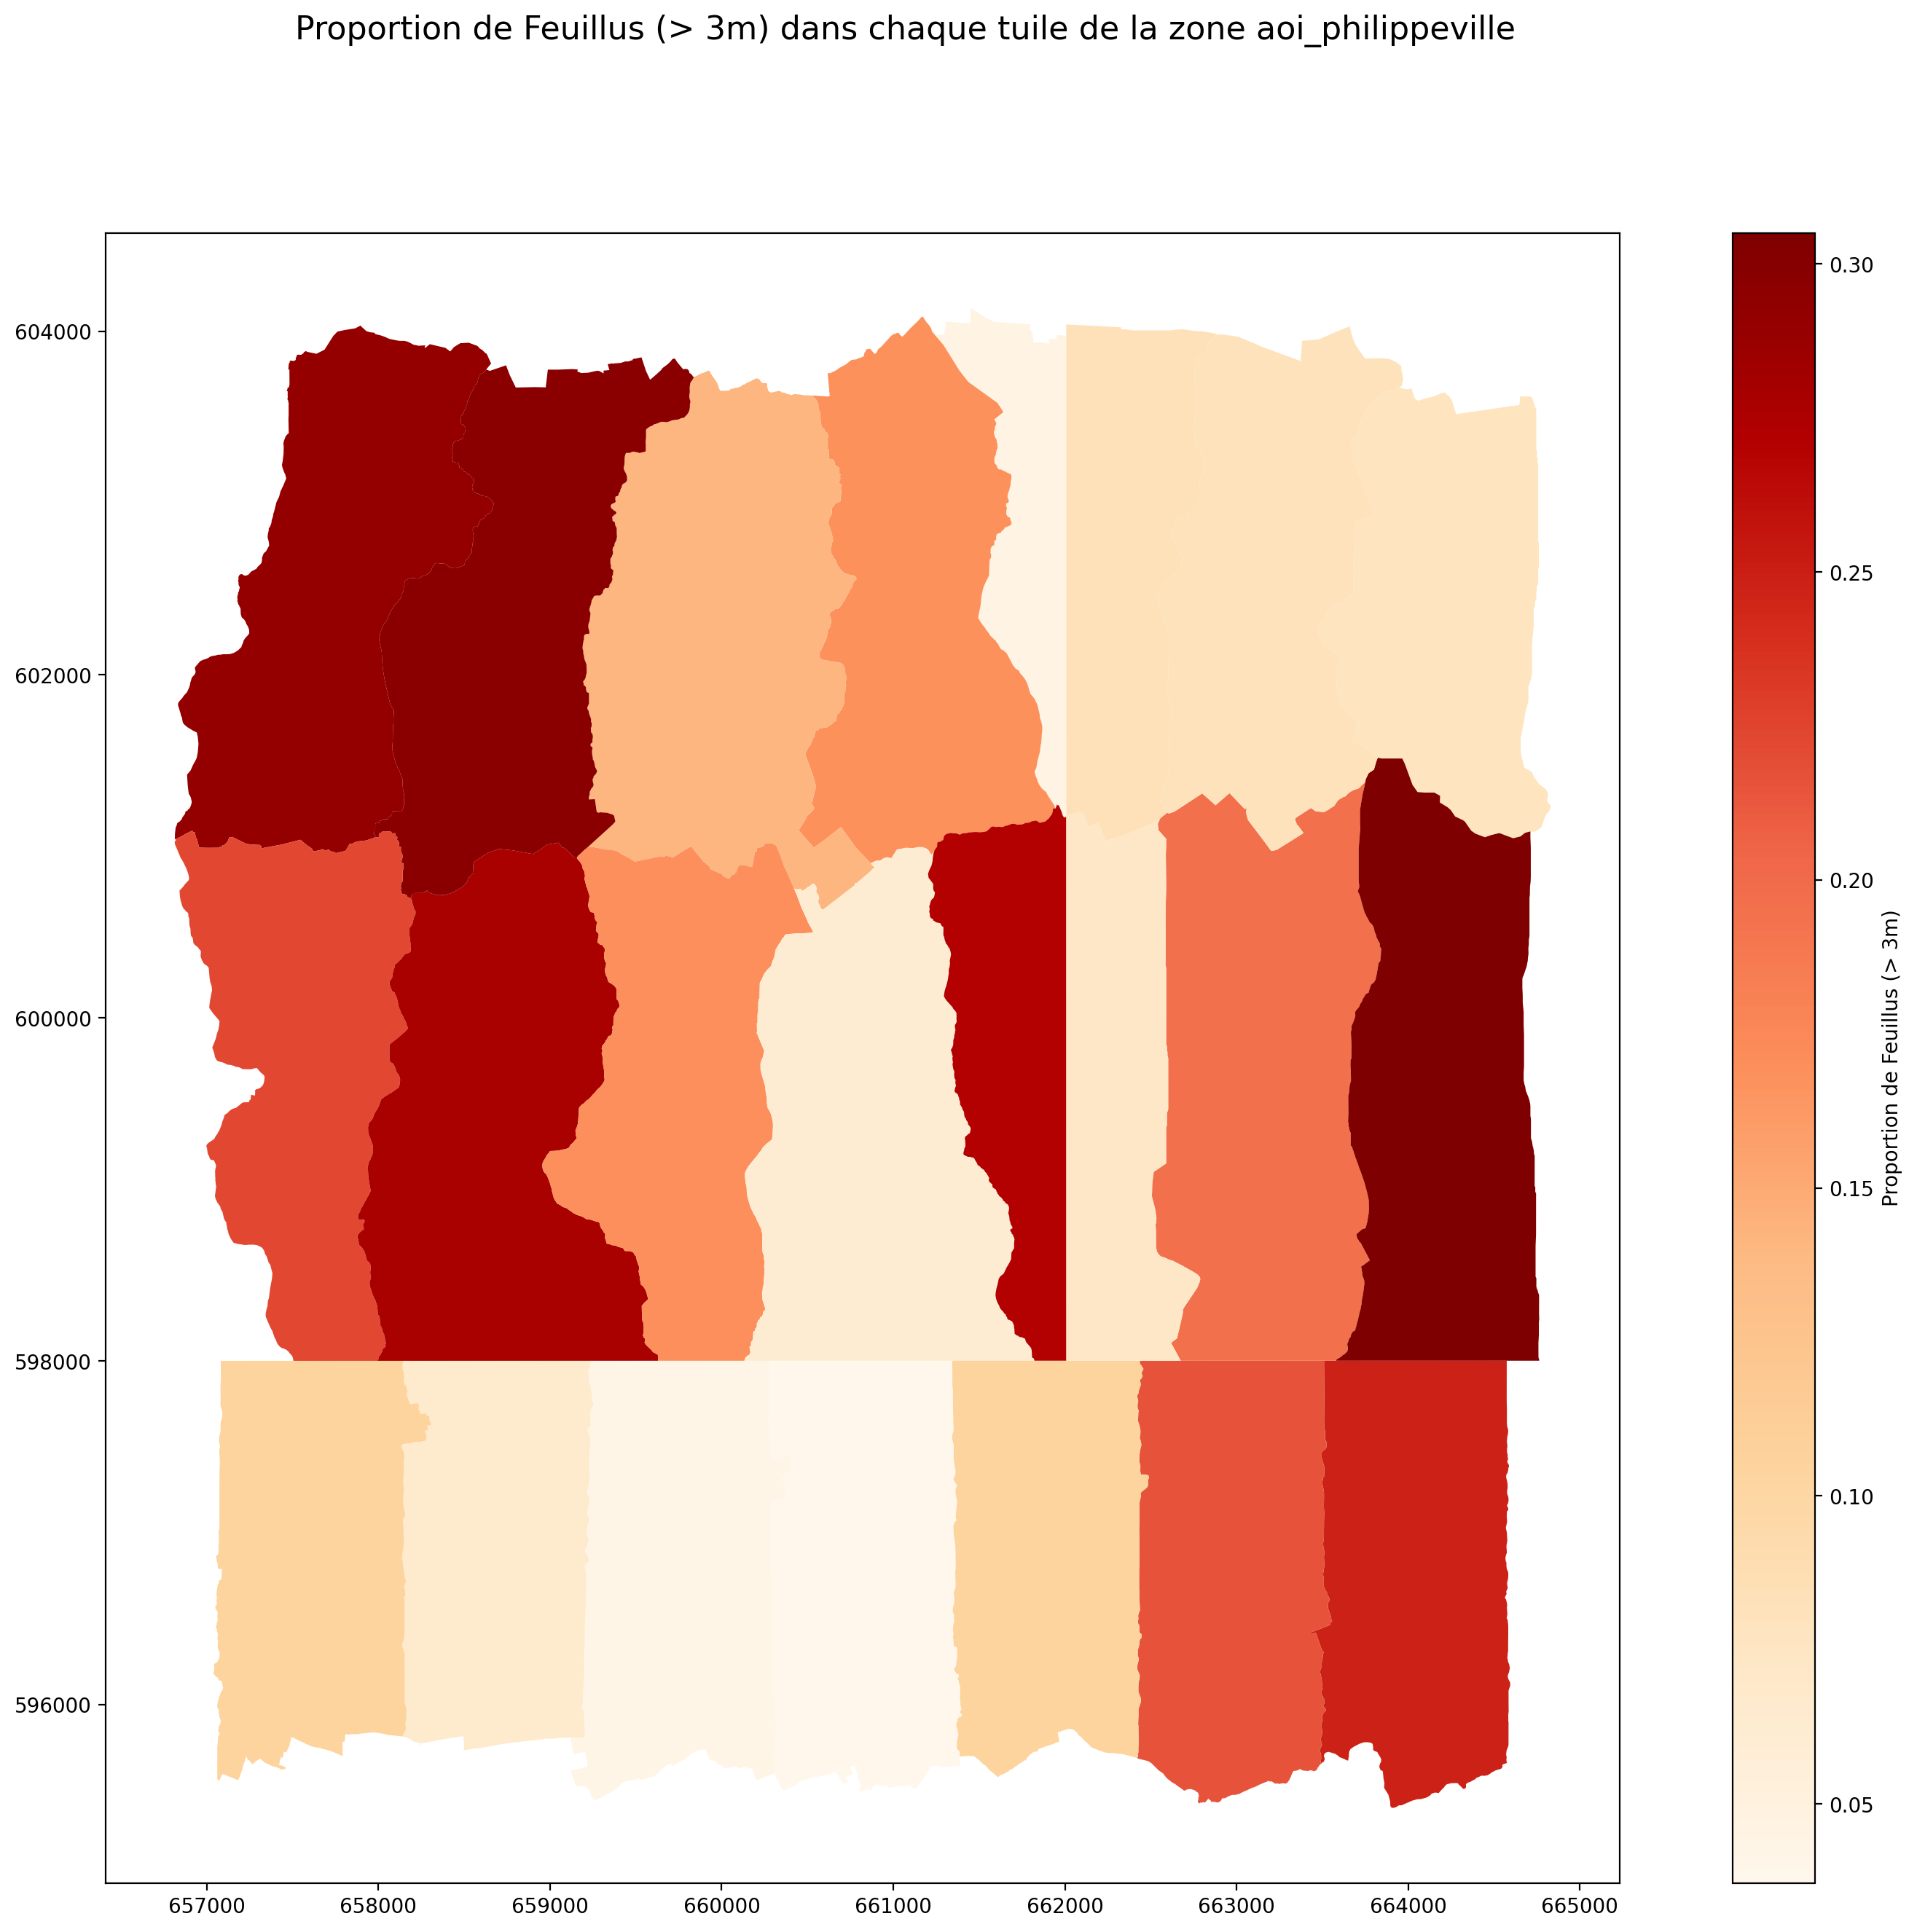

In [28]:
fig, ax = plt.subplots(
    nrows=1,
    ncols=1,
    figsize=(20,15),
)

fig.suptitle(
    f"Proportion de {OCS_TITLES[LABEL]} dans chaque tuile de la zone {Path(AOI_FP).stem}",
    fontsize=16
)

tuilage_gdf.plot(
    column='proportion',
    ax=ax,
    cmap='OrRd',
    legend=True,
    legend_kwds={
        "label": f"Proportion de {OCS_TITLES[LABEL]}",
        "orientation": "vertical",
    },
)

plt.rcParams['figure.dpi'] = 100

Notez qu'il vous est bien sûr possible de découper la zone d'intérêt de diverses autres façons que via les tuiles. Vous pourriez également utiliser les unités administratives. Pour se faire, au lieu de charger le fichier de tuilage, chargez votre propre fichier contenant par exemple les unités administratives.

#### Répartition des classes principales dans une zone d'intérêt

Nous pouvons maintenant nous demander quelles sont les proportions des autres classes dans chacune des _tuiles_ ayant une intersection avec notre zone d'intérêt. Nous illustrons cette répartition dans un diagramme en batons empilés.

Nous devons donc comparer la somme des surfaces des polygones d'une classe appartenant à une _tuile_ à la surface de cette même _tuile_:

In [23]:
# Définition des labels principaux
main_labels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 80, 90]

# Initialisation du DataFrame de décomposition
decomposition_df = pd.DataFrame(
    {x: [0] for x in main_labels},
    index=tuilage_gdf["OBJECTID"].unique(),
)

# Décomposition pour chaque tuile
for i, tuile in tuilage_gdf.iterrows():
    # Intersection des polygones avec la tuile
    intersection_gdf = gpd.overlay(
        vect_gdf,
        gpd.GeoDataFrame(geometry=[tuile.geometry], crs=tuilage_gdf.crs),
        how = "intersection",
    )

    # Regroupement par label
    intersection_gdf["area"] = intersection_gdf.geometry.area
    intersection_gdf.drop(columns=["geometry"], inplace=True)
    intersection_gdf = intersection_gdf.groupby(['label'], as_index=False).sum()

    # Calcul de la proportion
    intersection_gdf["proportion"] = intersection_gdf["area"] / tuile.geometry.area

    # Insertion des données dans le DataFrame de décomposition
    for i, label_proportion in intersection_gdf.iterrows():
        curr_label = label_proportion["label"]
        if curr_label in main_labels:
            decomposition_df.at[tuile["OBJECTID"], [curr_label]] = label_proportion["proportion"]

decomposition_df

,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,80.0,90.0
1327.0,0.019844,0.009501,0,0.000000,0.000000,0.467836,0.457099,0.000000,0.045719,0,0.000000
1328.0,0.009952,0.001499,0,0.108663,0.002874,0.345504,0.361845,0.000900,0.168763,0,0.000000
1329.0,0.049483,0.012263,0,0.032478,0.029411,0.309411,0.416627,0.008266,0.141811,0,0.000250
1330.0,0.031647,0.010571,0,0.000000,0.000285,0.259958,0.400762,0.000000,0.296777,0,0.000000
1331.0,0.000906,0.001123,0,0.000000,0.000000,0.571754,0.134309,0.001405,0.290503,0,0.000000
1373.0,0.001970,0.000959,0,0.000000,0.002877,0.397533,0.371672,0.001918,0.223070,0,0.000000
1374.0,0.003817,0.000496,0,0.000000,0.000993,0.393627,0.323410,0.000000,0.277657,0,0.000000
1375.0,0.015686,0.004480,0,0.000000,0.000000,0.530741,0.279482,0.000000,0.169610,0,0.000000
1376.0,0.040114,0.004997,0,0.000000,0.003419,0.540582,0.348971,0.000000,0.061916,0,0.000000
1377.0,0.063378,0.017576,0,0.000000,0.001035,0.062500,0.583992,0.000000,0.271518,0,0.000000


Nous pouvons maintenant visualiser ce `DataFrame` afin de savoir ce qui compose chaque tuile présentant une intersection avec notre zone d'intérêt:

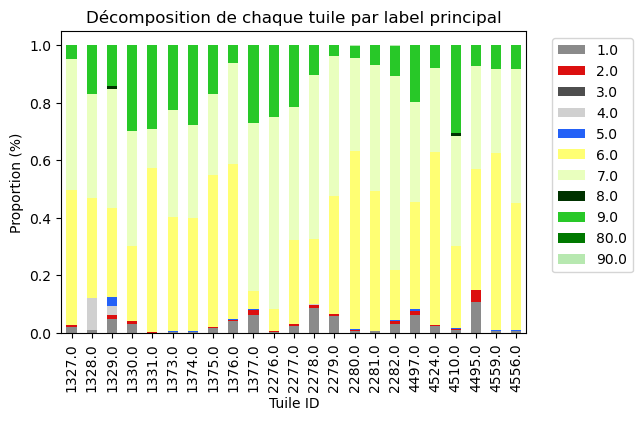

In [29]:
colors = [[x/255 for x in OCS_CMAP[ml]] for ml in main_labels]

decomposition_df.plot(kind='bar', stacked=True, color=colors)

plt.xlabel('Tuile ID')
plt.ylabel('Proportion (%)')

plt.rcParams["figure.figsize"] = (30,30)

plt.title('Décomposition de chaque tuile par label principal')

plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

plt.rcParams['figure.dpi'] = 100